# Mock Up of App for the Workshop

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stylia as st
from stylia import ONE_COLUMN_WIDTH, TWO_COLUMNS_WIDTH

DATAPATH = "../data"

## 1. Model Training

We will train a simple model using a dataset of 7000 molecules with measured activity against A.baumannii.

From the publication: "We first screened a diverse collection of 7,684 small molecules at 50 μM for those that inhibited the growth of A. baumannii ATCC 17978 in Lysogeny Broth (LB) medium (Fig. 1b and Extended Data Fig. 1a). This chemical collection consisted of both off-patent drugs (2,341 molecules) and synthetic chemicals (5,343 molecules) curated from various high-throughput screening sub-libraries at the Broad Institute. Using
a conventional hit cutoff of one standard deviation below the mean growth of the entire dataset resulted in 480 molecules being defined
as ‘active’ and 7,204 being defined as ‘inactive’ (Supplementary Data 1)."

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [8]:
df = pd.read_csv(os.path.join(DATAPATH, "training_sets", "eos3804.csv"))
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df.reset_index(drop=True, inplace=True)
df["Mean"] = pd.to_numeric(df["Mean"])

In [9]:
# original author's cut-off

mean_growth = np.mean(df["Mean"])
std_growth = np.std(df["Mean"])
print(mean_growth, std_growth)
cutoff= mean_growth-std_growth
print(cutoff)

0.9907789666022905 0.18499882302382487
0.8057801435784656


480 7204


Text(0, 0.5, 'Mean Growth')

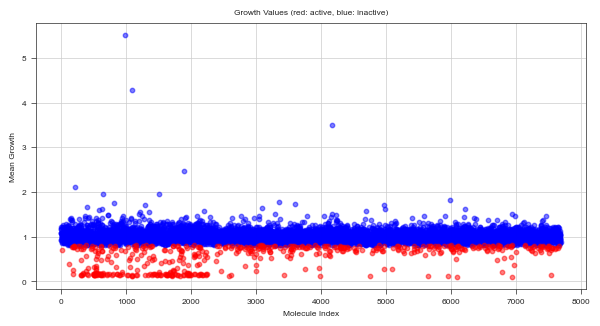

In [10]:
cutoff = 0.8057801435784656
active = df[df["Mean"] <= cutoff]
inactive = df[df["Mean"] > cutoff]

print(len(active), len(inactive))

## create active/inactive column
df["bin"] = [1 if x <= cutoff else 0 for x in df["Mean"].tolist()]

fig, axs = st.create_figure(1,1, ONE_COLUMN_WIDTH, TWO_COLUMNS_WIDTH)
ax = axs.next()
ax.scatter(inactive.index, inactive['Mean'], marker='o', color='blue', alpha=0.5)
ax.scatter(active.index, active['Mean'], marker='o', color='red', alpha=0.5)
ax.set_title('Growth Values (red: active, blue: inactive)')
ax.set_xlabel('Molecule Index')
ax.set_ylabel('Mean Growth')


In [ ]:
## chempfn
from chempfn import ChemPFN

y_hats = []
y_tests = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(df["SMILES"], df["bin"], test_size=0.2, stratify=df["bin"])
    clf = ChemPFN(max_iters=10)
    clf.fit(X_train, y_train)
    y_hat = clf.predict_proba(X_test)
    y_tests += [y_test]
    y_hats += [y_hat]

In [11]:
import lazyqsar as lq

y_hats = []
y_tests = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(df["SMILES"], df["bin"], test_size=0.2, stratify=df["bin"])
    model = lq.MorganBinaryClassifier(estimator_list = ["rf"]) 
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_test)
    y_tests += [y_test]
    y_hats += [y_hat]

ModuleNotFoundError: No module named 'lazyqsar'

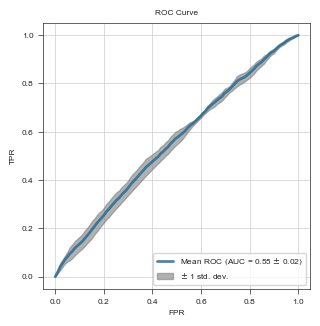

In [27]:
fig, axs = st.create_figure(1,1, ONE_COLUMN_WIDTH)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
ax = axs.next()
for i in range(5):
    fpr, tpr, _ = metrics.roc_curve(y_tests[i],y_hats[i][:,1])
    roc_auc = metrics.roc_auc_score(y_tests[i],y_hats[i][:,1])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="#1D6996",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.6,
    label=r"$\pm$ 1 std. dev.",
    )
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title = "ROC Curve",
    xlabel = "FPR",
    ylabel="TPR"
    )
ax.legend(loc="lower right")

### Questions:
- What is the experimental assay measuring?
- What is the author's defined cut-off?
- What have we chosen as a cut-off for activity against Abaumannii?
- Is it a balanced dataset?
- What is the performance of the models at different cut-offs?
- How does our quick modelling compare to the author's work?

## 2. QSAR

In [ ]:
# select model and obtain predictions - get a plot as well?



### Questions
For each model, answer:
- What type of model is it? 
- What is the model output?
- What is a good threshold for keeping molecules?

Finally, select the best candidate for the next steps

## 3. Generative modelling